You have to **add the root directory** to system path so that you can import all the necessary modules in this notebook correctly. **Important**: The **root directory is the directory two levels up from the current working directory**, and **one level up from the "adversarial_sampling_experiments" directory**.


In [1]:
import os
import sys
from pathlib import Path

two_up_dir = str(Path(os.getcwd()).parents[1]) # you have to cast to string otherwise it won't work.
print("current directory: ",os.getcwd())
print("two directories up: ",two_up_dir)

if two_up_dir not in sys.path:
    sys.path.append(two_up_dir)
    print("added root dir to sys.path: ",two_up_dir)
else:
    print("root dir: ",two_up_dir)

current directory:  C:\mlp_new\adversarial_sampling_experiments\attacks
two directories up:  C:\mlp_new
added root dir to sys.path:  C:\mlp_new


# Summary
- Adversarially attacking a batch of images and showing the results.
    - Fetching a batch of images.
- Prepare data for adversarial training.
    - Loading in a pre-trained model.
    - Saving the augmented dataset.
- Adversarially training a network.

The tests that we will perform will be using the MNIST dataset, and a simple feed forward neural network (FNN); but can easily be extended to more complicated datasets and models.

### Adversarially attacking a batch of images and showing the results
The hyperparameters of the attacks that we use are the same as the ones used to produce figure 3 in this paper: https://arxiv.org/pdf/1805.12152.pdf.

The above paper experiments with two types of attacks: **max-nrom PGD**, and **square-norm PGD**. The attacks are based on Madry's paper: https://arxiv.org/pdf/1706.06083.pdf

In appendix A.4 the author of the paper specify the $\epsilon$ used. For the MNIST dataset
- max-norm attack epsilon is 0.3,
- square-norm attack epsilon is 4.

Other hyper-parameters:
- **Intialization of PGD**. In appendix A.3 authors say they start PGD "from a random initial pertubation".
    - From the Madry's paper:  "Each run starts at a uniformly random point in the inf-ball around the same natural example"
- **Number of iterations to run PGD for**. From Madry's paper section 5 table 1:
    - "We run 40 iterations of projected gradient descent as our adversary, with a step size of 0.01 (we choose to take gradient steps in the ∞ norm, i.e. adding the sign of the gradient, since this makes the choice of the step size simpler). We train and evaluate against perturbations of size ε = 0.3"

Note: It may be interesting to do experiments with both small adversarial pertubations and high pertubations. Maybe high is better for correcting data imbalances?



use CPU
building feed-forward network module
torch.Size([2, 1, 28, 28]) input
torch.Size([2, 100]) fc-relu
torch.Size([2, 10]) fc


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 55.52it/s]


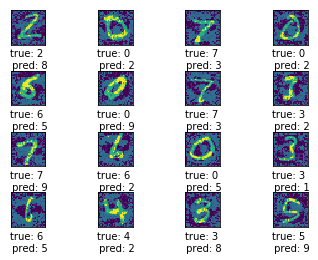

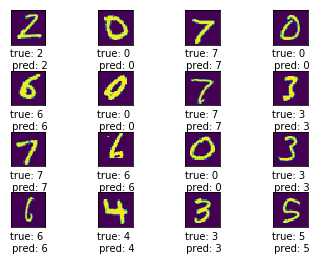

In [4]:
def show_images(x,model):
    plot_dict = {}
    fig, axs = plt.subplots(4, 4)
    axs = np.reshape(axs, (-1,))

    pred, _, _ = ModelQuery.predict(x, model)

    labels = ['true: {} \n pred: {}'.format(y[i], pred[i]) for i in range(len(y))]

    # labels = [i for i in range(len(y))]

    for i, (ax, img, label) in enumerate(zip(axs, x, labels)):
        plot_dict[i] = {'ax': ax, 'img': img, 'x_label': label}

    ImageDataViewer.grid(plot_dict, hspace=0.75)

x, y = ImageDataGetter.mnist(filename=os.path.join(ROOT_DIR, 'data/mnist-train.npz')) # (1)
data_iterator = DataProvider(x,y,batch_size=16,max_num_batches=1,make_one_hot=False,rng=None) # (2)
x, y = data_iterator.__next__()

model = FeedForwardNetwork(img_shape=(1, 28, 28), num_classes=10)
model.load_model(
    model_path=os.path.join(ROOT_DIR,'saved_models/simple_fnn/model_epoch_49') # (3)
)

attack = LInfProjectedGradientAttack(
    model = model,
    steps = 40,
    alpha = 0.01, # step size
    epsilon = 0.3,
    rand = True, # initialize at uniformly random feasible point
    targeted=False
)

x_adv = DataAugmenter.advers_attack(x,y,attack=attack)

show_images(x_adv,model)
show_images(x,model)